This notebook compares the updating speeds of different reservoirs.

**Timings are currently off due to not having jitted everything yet.**

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov  8 03:34:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 27.3 gigabytes of available RAM



In [ ]:
!pip install --upgrade pip # To support manylinux2010 wheels
!pip install --upgrade "jax[cuda111]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  # GPU
!pip install flax
!git clone https://github.com/GJBoth/jacho.git
%cd jacho
!sudo pip install . 

     |████████████████████████████████| 1.7 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html
     |████████████████████████████████| 786 kB 5.0 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.2.24-py3-none-any.whl size=903112 sha256=dce110b32c96e29da7d770efc5de6c5c6717566548c752b0da73f1c4c4518620
  Stored in directory: /root/.cache/pip/wheels/28/a9/0f/3497740c85f6e1de8f4d291fd2f77d046d66a87620143d0d0e
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.2.21
    Uninstalling jax-0.2.21:
      Successfully uninstalled jax-0.2.21
     |████████████████████████████████| 207 kB 5.0 MB/s            
     |████████████████████████████████| 118 kB 61.9 MB/s            
     |████████████████████████████████| 57 kB 5.6 MB/s 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd ..
%cd drive/MyDrive/Colab_Notebooks
import res_speed_test

/content/drive/MyDrive/Colab_Notebooks


In [ ]:
from jacho.layers.reservoirs import RandomReservoir, StructuredTransform, FastStructuredTransform, SparseReservoir
from jacho.models.generic import GenericEchoState
from jacho.layers.output import Residual
from jacho.training.training import ridge
from jacho.data.KS import KS

from jax import random
import numpy as np
import jax.numpy as jnp
from jax import jit
from flax import linen as nn

import matplotlib.pyplot as plt

key = random.PRNGKey(42)

In [ ]:
# Setting up our dataset; similar to jonathans
L = 22 / (2 * np.pi)  # length
N = 32  # space discretization step
dt = 0.25  # time discretization step
N = 1000
N_init = 1000  # remove the initial points
tend = (N + N_init - 1) * dt
np.random.seed(2)
dns = KS(L=L, N=N, dt=dt, tend=tend)
dns.simulate()
u = np.expand_dims(dns.uu, axis=1)
_, input_data = np.split(u / np.sqrt(N), [N_init, ], axis=0)

In [ ]:
n_res_min = 1000
n_res_max = 100000
num_res = 20
n_reservoirs = np.logspace(np.log10(n_res_min), np.log10(n_res_max), num_res, dtype="uint32")

faststructured_times = res_speed_test.res_update_time(input_data, reservoir_type=FastStructuredTransform, n_reservoirs=n_reservoirs, reservoir_args=(0.5, 0.5, 0))/N

FSR_time_benchmark = np.concatenate([[n_reservoirs], [faststructured_times]], axis=0)
np.save("FSR_time_benchmark.npy", FSR_time_benchmark)

In [ ]:
n_res_min = 1000
n_res_max = 4000
num_res = 5
n_reservoirs = np.logspace(np.log10(n_res_min), np.log10(n_res_max), num_res, dtype="uint16")

structured_times = res_speed_test.res_update_time(input_data, StructuredTransform, n_reservoirs = n_reservoirs, reservoir_args = (0.5, 0.5, 0))/N

SR_time_benchmark = np.concatenate([[n_reservoirs], [structured_times]], axis=0)
np.save("SR_time_benchmark.npy", SR_time_benchmark)

In [ ]:
n_res_min = 1000
n_res_max = 30000
num_res = 15
n_reservoirs = np.logspace(np.log10(n_res_min), np.log10(n_res_max), num_res, dtype="uint16")

randomreservoir_times = res_speed_test.res_update_time(input_data, RandomReservoir, n_reservoirs = n_reservoirs, reservoir_args = (0.5, 0.5, 0))/N

RR_time_benchmark = np.concatenate([[n_reservoirs], [randomreservoir_times]], axis=0)
np.save("RR_time_benchmark.npy", RR_time_benchmark)

In [ ]:
n_res_min = 1000
n_res_max = 45000
num_res = 20
n_reservoirs = np.logspace(np.log10(n_res_min), np.log10(n_res_max), num_res, dtype="uint16")

sparsereservoir_times = res_speed_test.res_update_time(input_data, SparseReservoir, n_reservoirs = n_reservoirs, reservoir_args = (0.1, 0.5, 0.5, 0))/N

SparseR_time_benchmark = np.concatenate([[n_reservoirs], [sparsereservoir_times]], axis=0)
np.save("SparseR_time_benchmark.npy", SparseR_time_benchmark)

In [ ]:
RR_time_benchmark = np.load("RR_time_benchmark.npy")
SR_time_benchmark = np.load("SR_time_benchmark.npy")
FSR_time_benchmark = np.load("FSR_time_benchmark.npy")
SparseR_time_benchmark = np.load("SparseR_time_benchmark.npy")

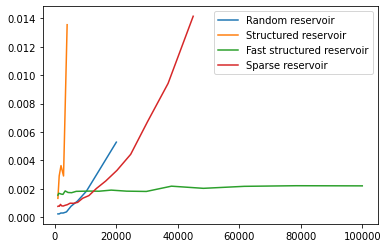

In [ ]:
plt.plot(RR_time_benchmark[0], RR_time_benchmark[1])
plt.plot(SR_time_benchmark[0], SR_time_benchmark[1])
plt.plot(FSR_time_benchmark[0], FSR_time_benchmark[1])
plt.plot(SparseR_time_benchmark[0], SparseR_time_benchmark[1])
plt.legend(["Random reservoir", "Structured reservoir", "Fast structured reservoir", "Sparse reservoir"])